# Exploration des forms et des mots

## Définition des constantes

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from lxml import etree  # pour la fonction get_words_from_xml_form()
import glob  # pour la fonction get_files()
from collections import Counter
import cv2

import ressources as rss
import preprocessing as pp
import dataviz as dv
import rendering as rd

In [35]:
# UNIQUEMENT UTILE pour recharger les librairies plus rapidement lors des devs
import importlib
importlib.reload(rss)
importlib.reload(pp)
importlib.reload(dv)
importlib.reload(rd)

<module 'rendering' from 'd:\\GitHub\\OCRpyMAN\\notebooks\\rendering.py'>

In [3]:
# initialisation des variables globales
rss.init()

## Preprocessing

### Lecture des données des forms dans un dataframe : form_df

In [4]:
form_df = pd.DataFrame(pp.parse_my_form_file(rss.FORMS_META_FILENAME), columns=rss.FORMS_COLUMNS)
#form_df.head()

In [5]:
%%capture 

form_df = pp.prepro_form(form_df)

In [6]:
print('Le dataset des forms dispose de ' + str(form_df.shape[0]) +' entrées.')

Le dataset des forms dispose de 1539 entrées.


In [7]:
# %%time

pp.check_all_forms_images(form_df)

Tous les fichiers des forms sont accessibles


,form_id,writer_id,text_id,number_of_sentences,word_seg,total_lines,correct_lines,total_words,correct_words,form_img_path
0,a01-000u,000,a01,2,prt,7,5,52,36,../data/formsA-D/a01-000u.png
1,a01-000x,001,a01,2,all,6,6,52,52,../data/formsA-D/a01-000x.png
2,a01-003,002,a01,3,prt,11,10,81,71,../data/formsA-D/a01-003.png
3,a01-003u,000,a01,3,prt,11,10,80,73,../data/formsA-D/a01-003u.png
4,a01-003x,003,a01,3,prt,9,6,82,56,../data/formsA-D/a01-003x.png
...,...,...,...,...,...,...,...,...,...,...
1534,r06-121,671,r06,4,all,11,11,84,84,../data/formsI-Z/r06-121.png
1535,r06-126,671,r06,3,all,11,11,81,81,../data/formsI-Z/r06-126.png
1536,r06-130,671,r06,6,prt,10,9,83,76,../data/formsI-Z/r06-130.png
1537,r06-137,671,r06,5,all,11,11,96,96,../data/formsI-Z/r06-137.png


### Lecture des données des mots dans un DF : word_df

In [8]:
word_df = pd.DataFrame(pp.parse_my_word_file(rss.WORDS_META_FILENAME), columns=rss.WORD_COLUMNS)
word_df.head()

,word_id,seg_res,gray_level,x,y,w,h,tag,transcription
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.


In [9]:
%%capture  #no_output

word_df = pp.prepro_word(word_df)

In [10]:
print('Le dataset des mots dispose de ' + str(word_df.shape[0]) +' entrées.')

Le dataset des mots dispose de 96418 entrées.


Deux fichiers de mots sont corrompus [4152, 113621]. Ils sont supprimés du dataframe. Les mots mal segmentés sont également supprimés.

Le dataset dispose de 115318 mots scannés, dont 96420 mots avec segmentation OK, qui constitueront notre base finale.

In [11]:
# Création du dataframe mergé
df_all = pp.prepro_all(word_df, form_df)

## Outils de rendering

### Affichage des forms et des mots

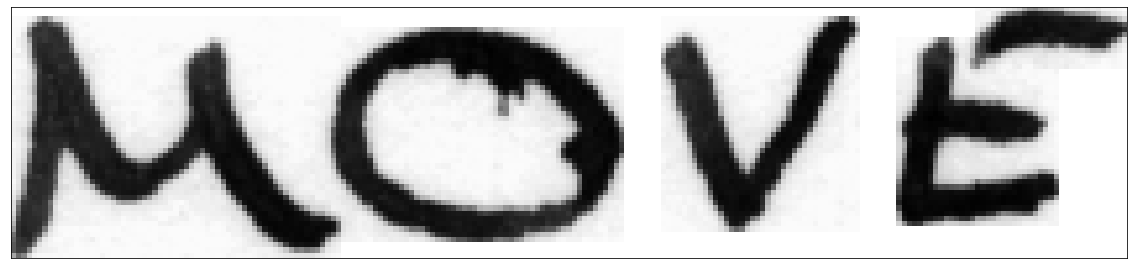

In [25]:
rd.show_word_image_by_line(word_df.iloc[1])

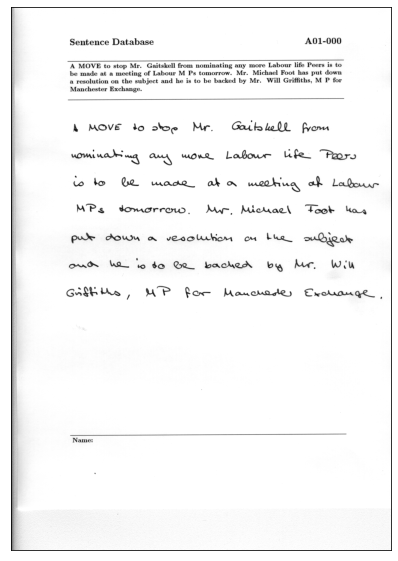

In [24]:
rd.show_form_img_by_word_id(form_df.iloc[0])

### Affichage des contours sur les forms

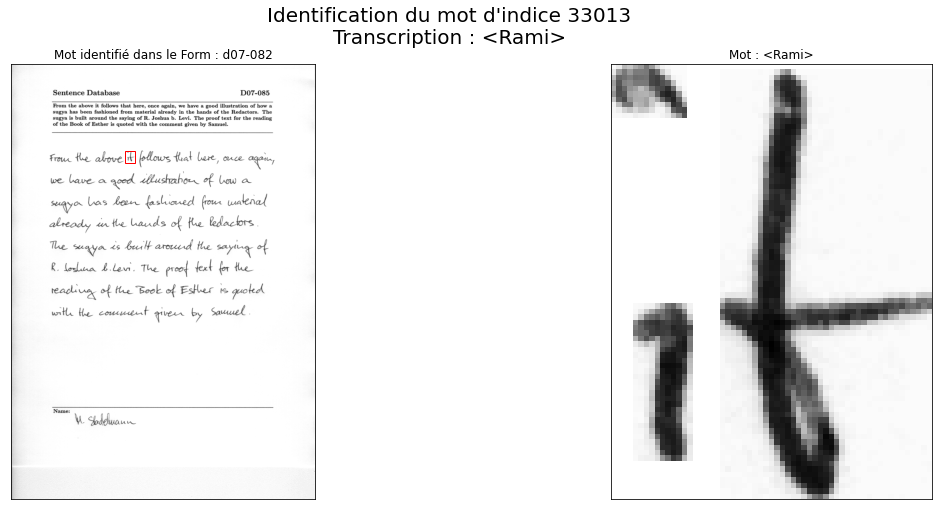

In [36]:
indice = np.random.randint(0, word_df.shape[0])


rd.plot_bounding_box_with_form(indice, word_df)

## Analyse des Forms

### Représentation globale des forms

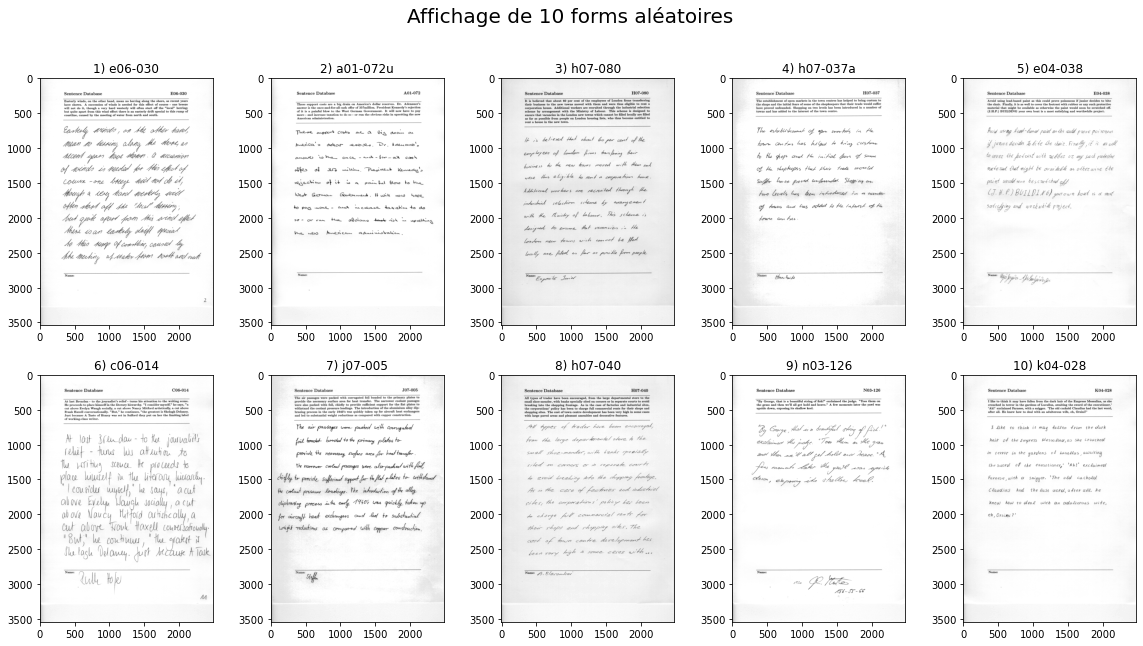

In [15]:

rd.show_10_forms(form_df)

### Analyse du volume de lignes et mots par form

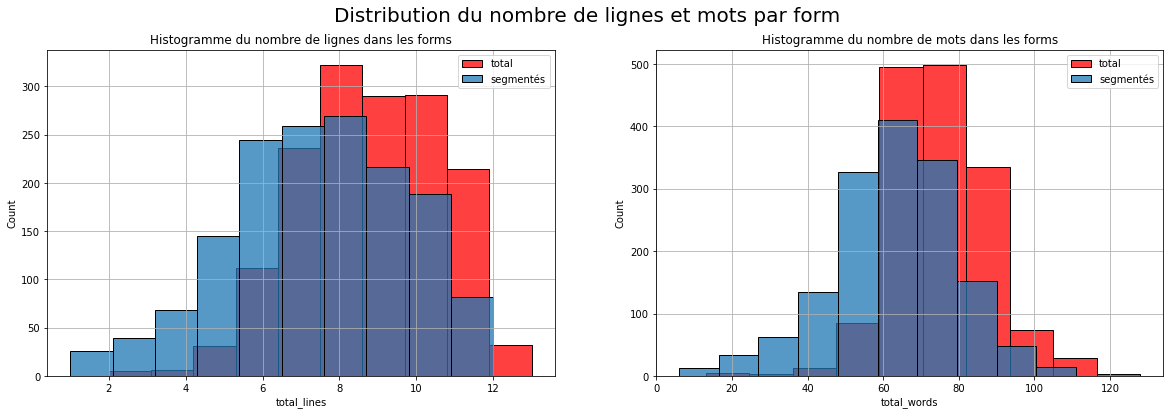

In [16]:


dv.show_lines_word_per_form(form_df)

### Analyse de la distribution de rédacteurs et de textes

In [17]:
nb_textes = len(form_df.text_id.unique())
nb_auteurs = len(form_df.writer_id.unique())

print('Le dataset de forms est constitué de '+str(nb_textes)+' textes uniques rédigés par '+str(nb_auteurs)+' rédacteurs.')
      

Le dataset de forms est constitué de 76 textes uniques rédigés par 657 rédacteurs.


         nb_forms
count  657.000000
mean     2.342466
std      3.033337
min      1.000000
25%      1.000000
50%      1.000000
75%      2.000000
max     59.000000


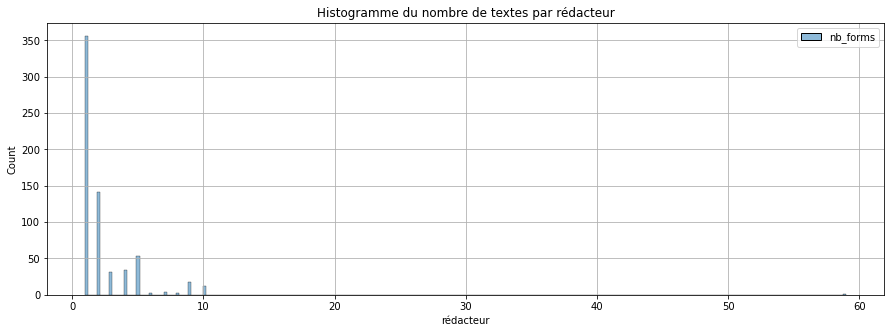

In [72]:
count_per_writer_df = form_df[['writer_id', 'form_id']].groupby("writer_id").count()
count_per_writer_df.columns = ['nb_forms']

#juste pour filtrer l'outlier
# count_per_writer_df = count_per_writer_df[count_per_writer_df['nb_forms'] < 20]

print(count_per_writer_df.describe())
dv.show_count_per_wirter(count_per_writer_df)

On remarque une moyenne de 2,34 forms par rédacteur et un écart moyen de l'ordre de 3 avec un minimum de 1 et un maximum de 59: Il semble donc y avoir un/des outliers.

Le rédacteur ayant l'identifiant 000 a un volume beaucoup plus important que tous les autres rédacteurs.
Hypothèse à tester : l'indice 000 indique un rédacteur inconnu.

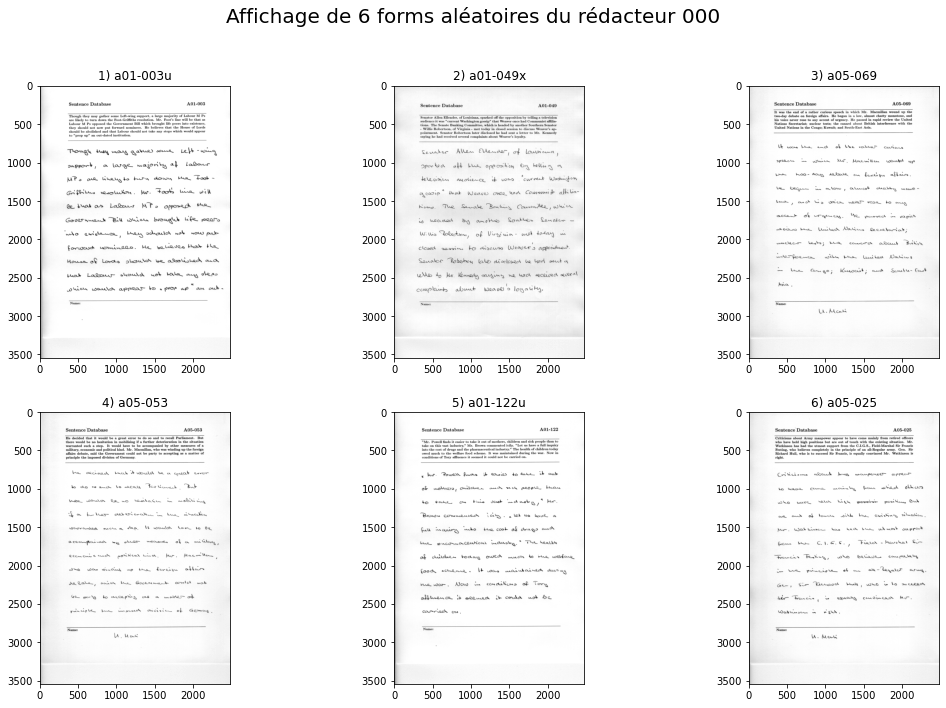

In [19]:
rd.show_6forms_from_writer000(form_df)

L'hypothèse n'est pas retenue. L'indice 000 semble indiquer un seul rédacteur.

In [20]:
# A CONSERVER?

# matrice = pd.crosstab(form_df['text_id'], form_df['writer_id'])

# fig = plt.figure(figsize = (12,8))
# sns.heatmap(matrice**.2, cmap = 'viridis',cbar = False)
# plt.title('Croisement entre textes et rédacteurs', fontsize=15);

Cette visualisation en heatmap montre une matrice très diaginalisée en marches, ce qui veut dire que, globalement, chaque nouvel rédacteur à eu des nouveaux textes à réddiger. En conséquence, il n'y pas beaucoup de textes rédigés par différents rédacteurs.

## Analyse des mots

### Représentation globale des mots

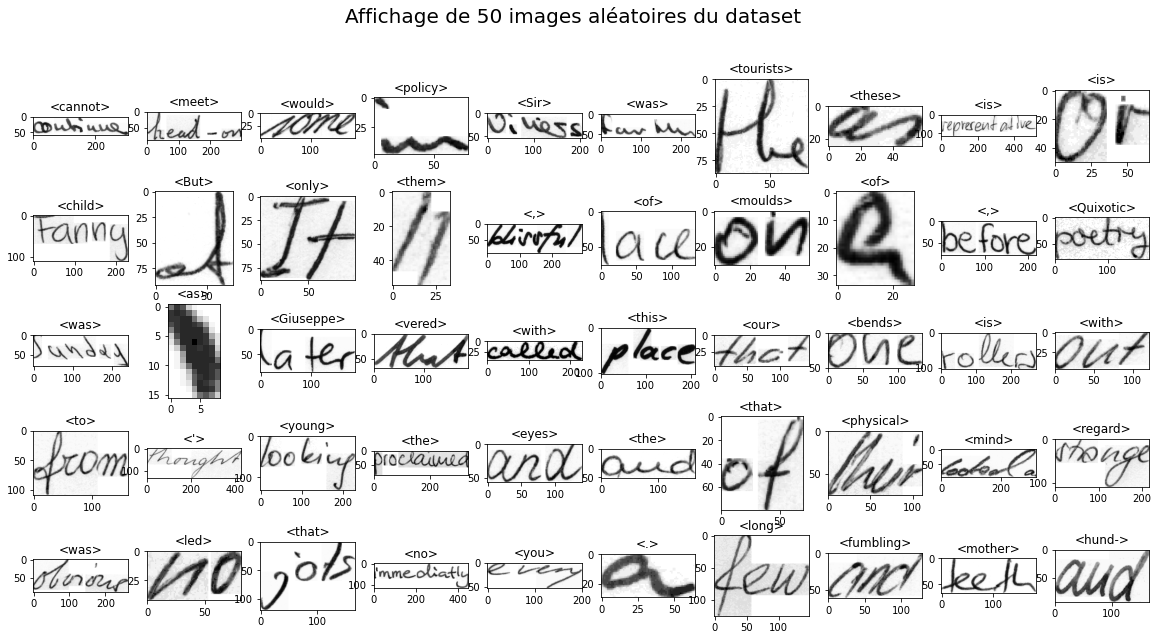

In [21]:
rd.show_50_random_words(word_df)

### Analyse du contraste des images mots

#### Images avec contraste nul

In [22]:

print('Nombre de mot dont l\'image a un contraste nul : ', word_df[word_df['michelson_contrast'] == 0].shape[0])
rd.show_images_with_contraste_0(word_df)

Nombre de mot dont l'image a un contraste nul :  0


ValueError: high <= 0

In [ ]:
# A CONSERVER?
# plt.figure(figsize=(15,5))
# sns.countplot(x='transcription', data = bad_contrast_df, order = bad_contrast_df.transcription.value_counts().index)
# plt.title('Occurrence des images avec un contraste égale = 0')
# plt.grid();

Il a un total de 132 images avec une image de contraste nul avec un mélange de pontuaction et mots. Avant de retirer ces mots du dataset, on peut vérifier s'il apparaissent à d'autres indices du dataset pour s'assurer que leur représentativité n'est pas impactée.

In [37]:
dv.show_nb_words_having_some_contrast_0(word_df)

ValueError: min() arg is an empty sequence

<Figure size 1080x360 with 0 Axes>

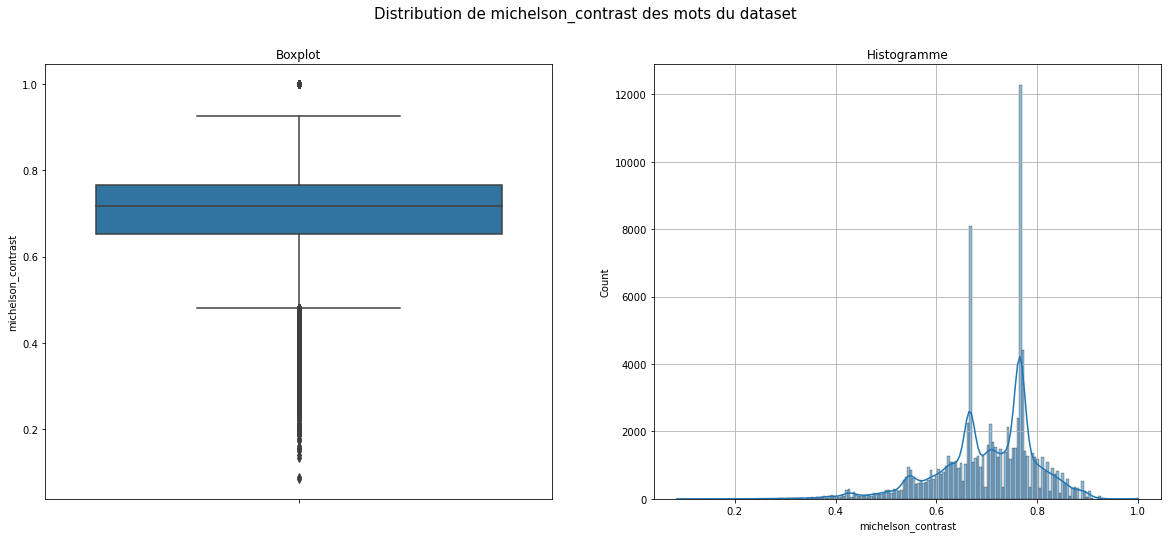

In [39]:
dv.show_contrast_distribution(word_df)

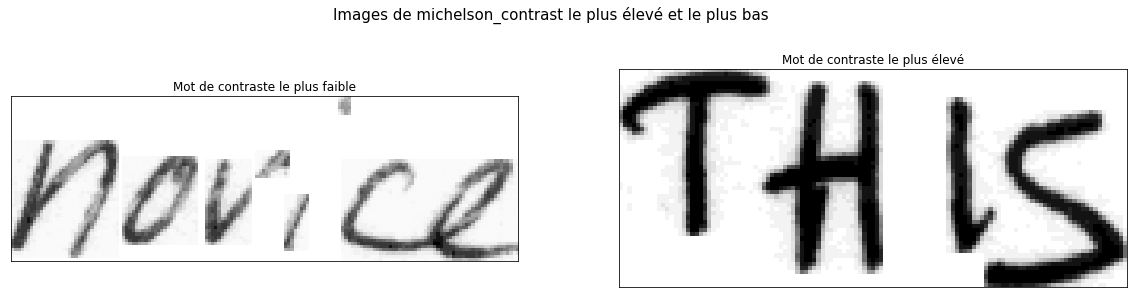

In [38]:
dv.show_min_max_contrast_images(word_df)

L'image au contraste le plus petit reste lisible, nous pouvons ainsi considérer les autres images comme lisibles.

### Analyse du niveau de gris des lignes

<span style="color: red">
Warning : le gray_level du dataset initial correspond au gray_level de la ligne scannée et pas celui du mot.
</span>

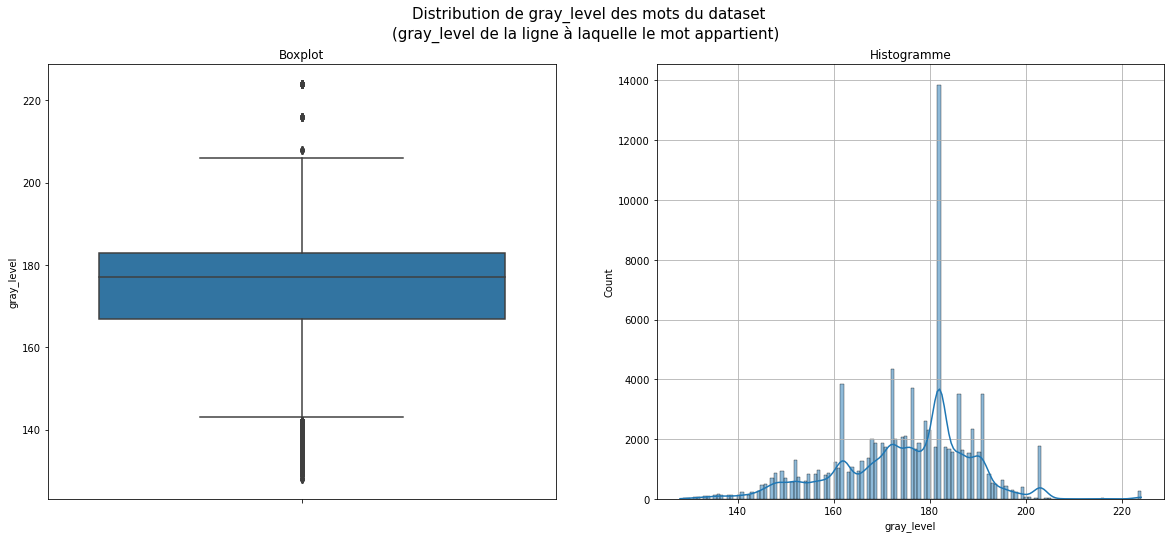

In [40]:


dv.show_gray_level_distribution(word_df)

Nous remarquons une concentration des niveaux de gris autour de la médiane (177) avec une déviation moyenne standard légère (seulement 13.8). 

Nous pouvons ainsi nous poser la question suivante : comment réagira notre modèle en présence de valeurs extrêmes traits légers aux couleurs claires et traits épaix aux couleurs sombres?

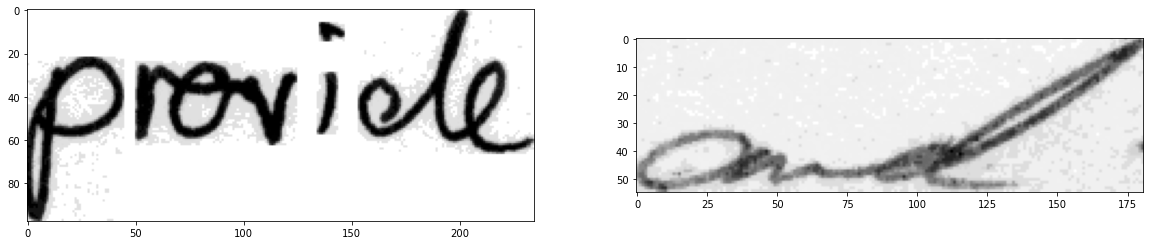

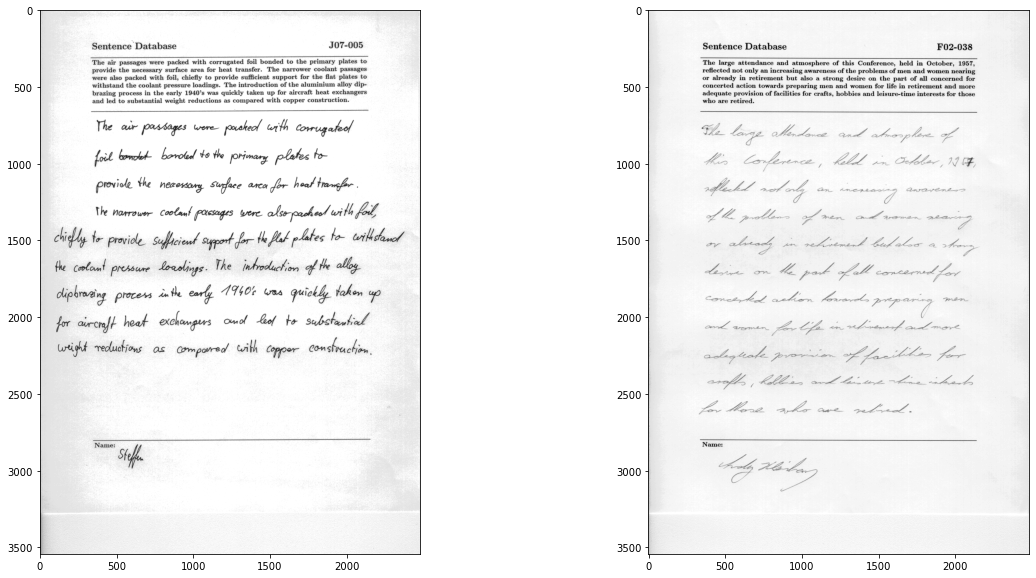

In [41]:

dv.show_min_max_gray_level_images(word_df)


Les images du dataset sont toutes réalisées dans de bonnes conditions pour ce qui est du contraste entre le texte et le fond. Il n'y a pas de reliefs, de couleurs ou de motifs pouvant rendre l'extraction de texte difficile.

#### Affichage global

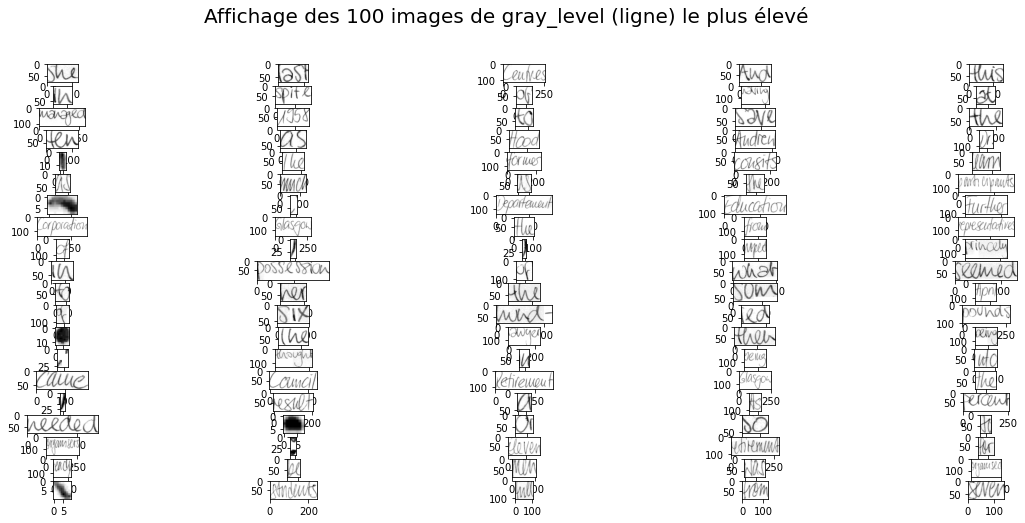

In [42]:

rd.show_100max_gray_level_images(word_df)

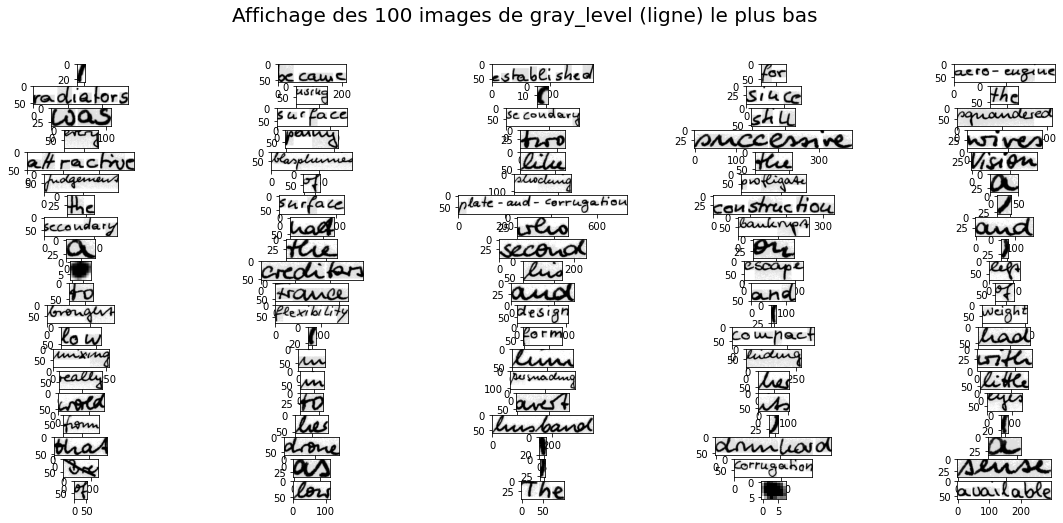

In [43]:


rd.show_100min_gray_level_images(word_df)

### Analyse du niveau de gris des mots

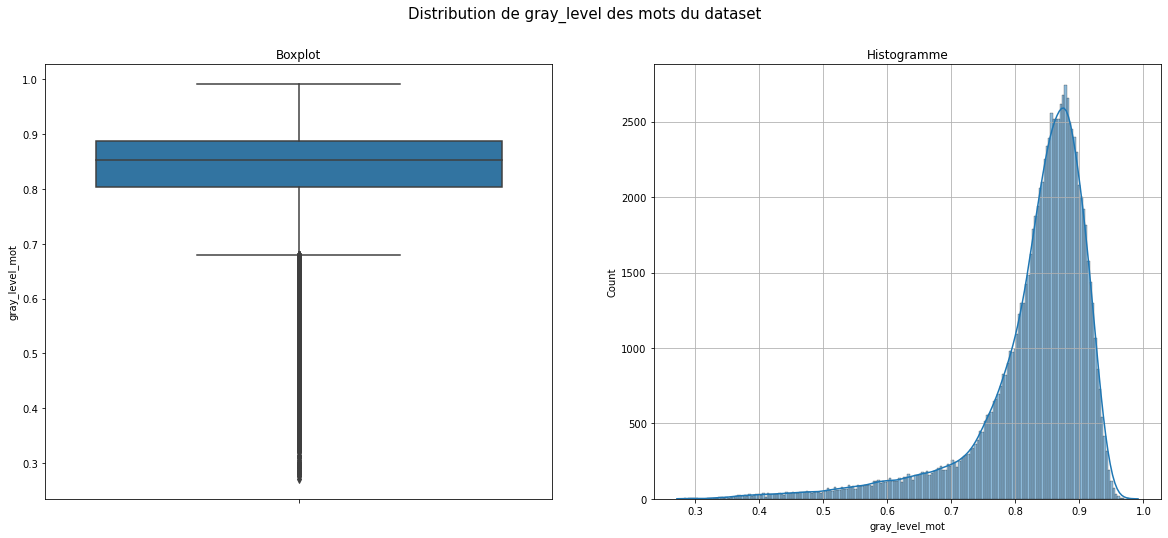

In [44]:
dv.show_gray_level_per_word(word_df)

#### Représentation globale

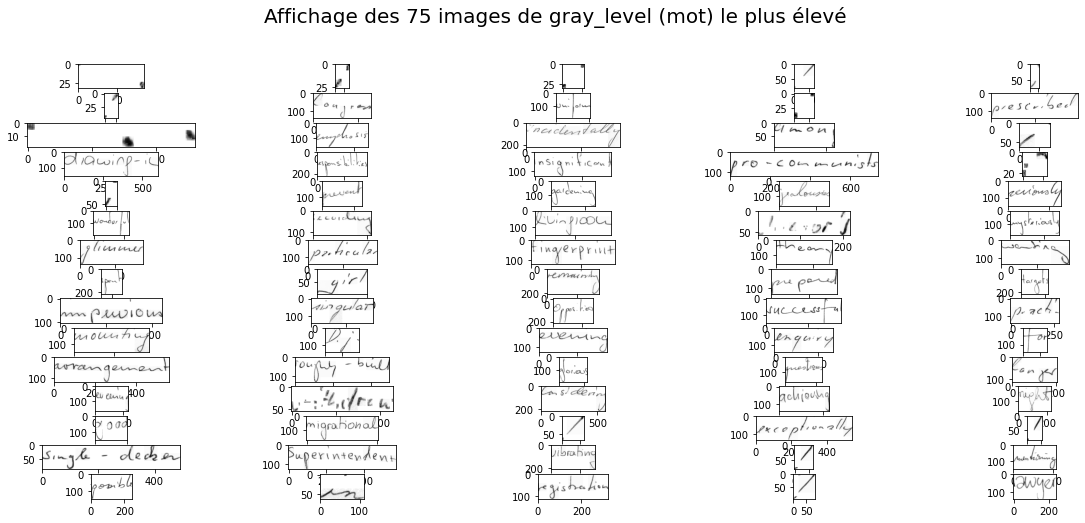

In [45]:
rd.show_75max_gray_level_word_images(word_df)

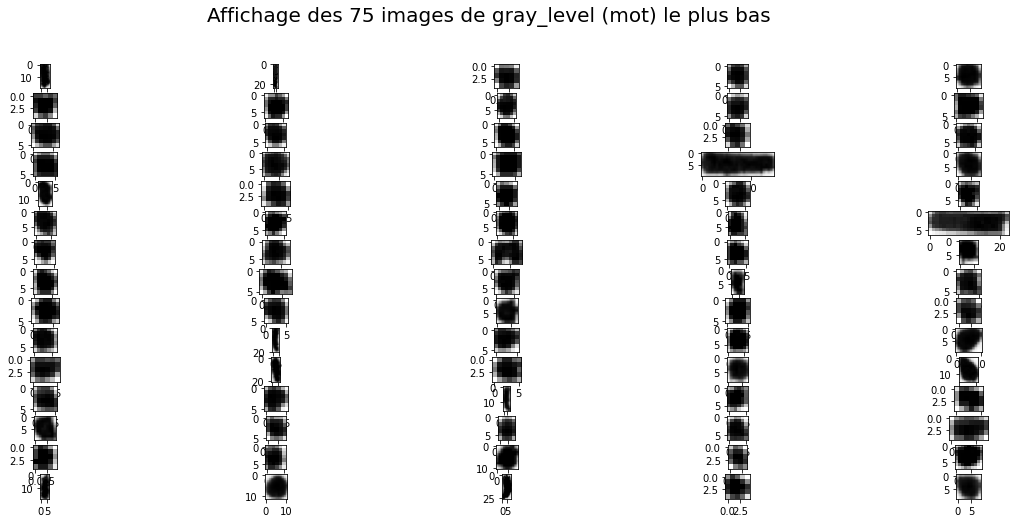

In [46]:
rd.show_75min_gray_level_word_images(word_df)

In [ ]:
# A CONSERVER? 3 cellules suivantes

### Mise en relation du niveau de gris d'une ligne et d'un mot

In [ ]:
#from scipy.stats import pearsonr

#pearsonr(df.gray_level, df.gray_level_mot)

In [ ]:
#plt.figure(figsize = (15,8))
#sns.scatterplot(data=df[df['seg_res']==1], x='gray_level', y='gray_level_mot')
#plt.title('Relation entre gray_level mot et gray_level ligne')
#plt.grid()

### Analyse de la répartition des mots dans le corpus

In [ ]:
# A CONSERVER?

# %%time
# matrice2 = pd.crosstab(df_temp['writer_id'], df_temp['transcription'])                                
                                
# fig = plt.figure(figsize = (20,12))
# sns.heatmap(matrice2, cmap = 'viridis',cbar = False)
# plt.title('Croisement entre mots et rédacteurs', fontsize=15);

### Analyse de la répartition des lettres dans le corpus

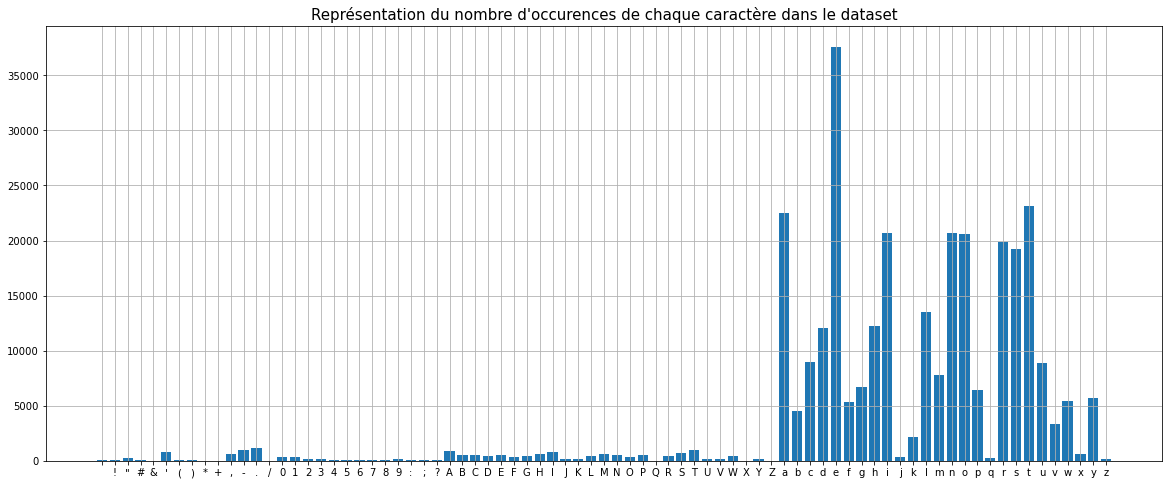

In [47]:
dv.show_letters_occurences(df_all)

Nous pouvons observer une grosse disparité dans les représentations de chacune des lettres.
Les lettres 'j', 'k', 'q', 'x' et 'z' notamment sont très peu représentées. 

A l'inverse, les lettres 'e', 'a' et 't' sont très présentes. 



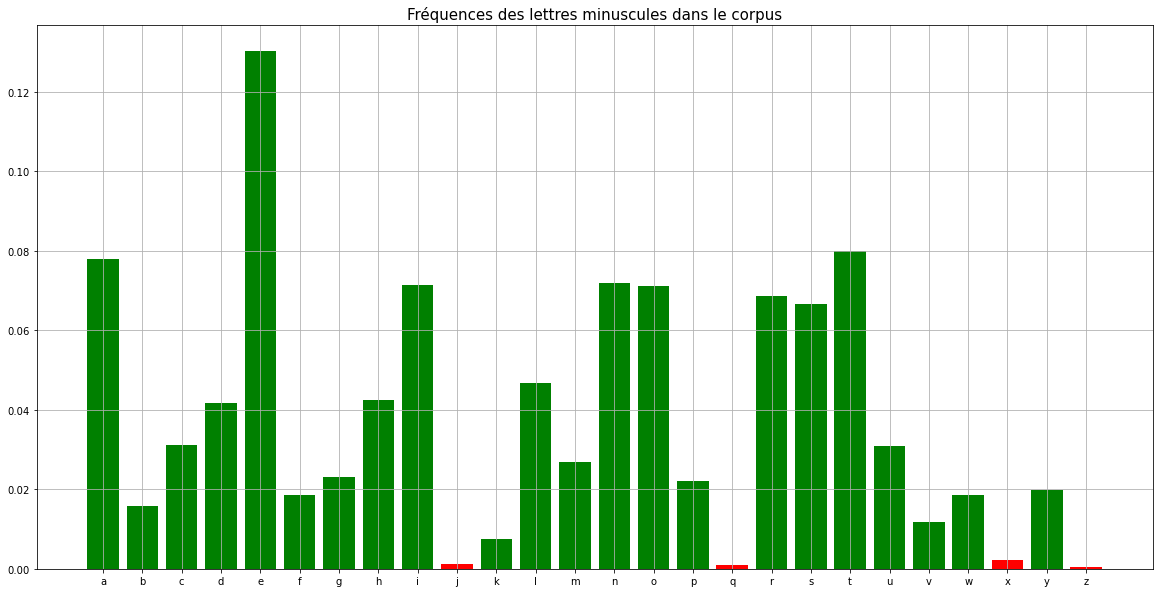

In [48]:
dv.show_lower_letters_frequency(df_all)

Cette distribution peut être mise en paralèlle avec la distribution des lettres dans la langue anglaise. 

En effet, notre objectif étant de créer une reconnaissance de caractères, plus notre modèle aura l'habtiude de traiter des lettres fréquentes correctement, meilleures seront nos chances de réussite, à defaut d'avoir un dataset plus conséquent.

Or, les fréquences des lettres anglaises semblent bien concordées avec la distribution de notre corpus. Le corpus est donc bien représentatif.

<img src="../images/english_letter_distribution.png" />

Source: https://www3.nd.edu/~busiforc/handouts/cryptography/letterfrequencies.html

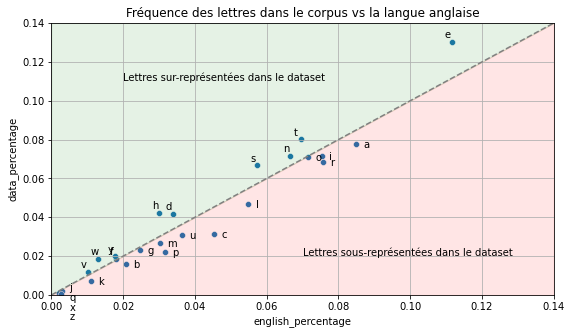

In [49]:
dv.show_letters_repartition_with_english(df_all)

On peut par contre se demander comment réagirait notre modèle à une autre langue dont la répartition des lettres serait différente.

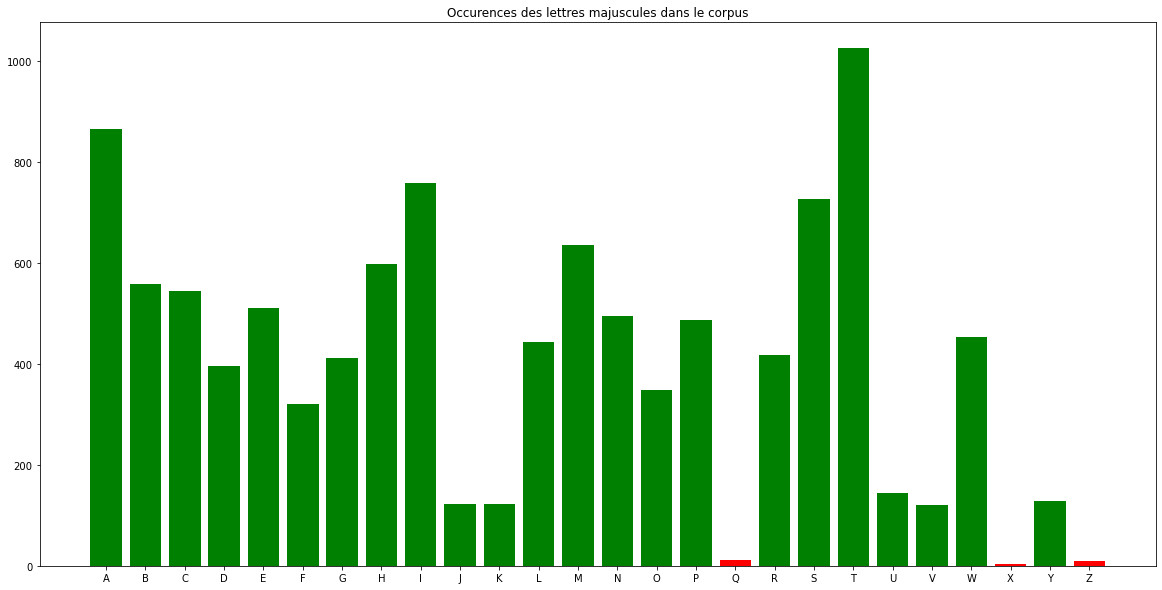

In [50]:
dv.show_upper_letters_frequency(df_all)

On remarque cependant une sous représentation des majuscules dans le dataset. Les représentations des majuscules étant radicalement différentes des minuscules, il se peut que notre modèle manque de données d'entraînement pour, par la suite, bien distinguer des majuscules.

### Longueur des mots

## Position et taille des boîtes

```
file n06-128.png
```

Output:
`n06-128.png: PNG image data, 2479 x 3542, 8-bit grayscale, non-interlaced`


### Position des boîtes

In [51]:
# A CONSERVER??

print(word_df['x'].max())
print(word_df['y'].max())
word_df[(word_df['x'] == -1) | (word_df['y'] == -1) | (word_df['h'] == -1) | (word_df['w'] == -1)].head()

2471
2776


,index,word_id,seg_res,gray_level,x,y,w,h,tag,transcription,word_img_path,form_img_path,michelson_contrast,gray_level_mot,form_id


Il ne reste plus de mots dont le positionnement n'a pas été trouver. Nous pouvons donc analyser la répartition des boîtes dans notre dataset.

In [ ]:
# A CONSERVER?? Ici?

# Need ten minutes to run
#dv.show_text_position_over_dataset(df_all)

<img src="../images/text_box_position.png">

### Taille des boîtes

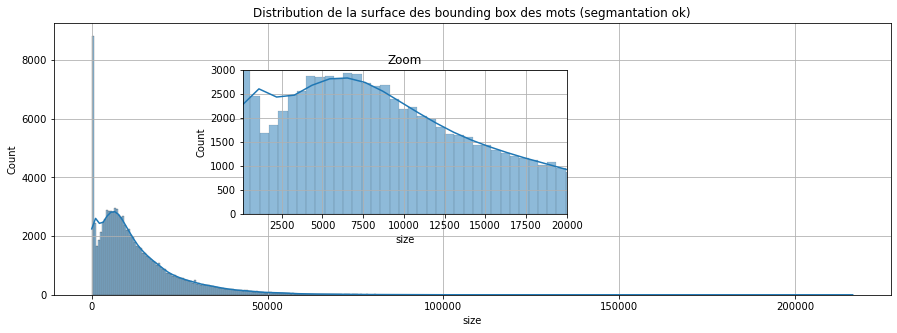

In [52]:


dv.show_bounding_boxes_size(word_df)

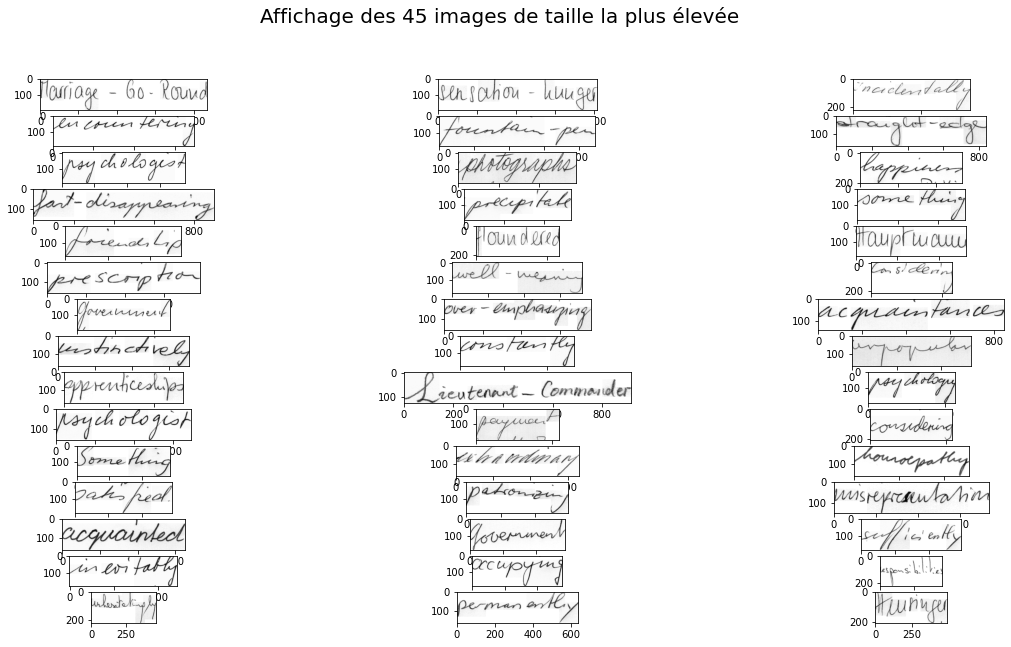

In [53]:
# A DEPLACER PLUS HAUT AVEC LE RESTE DES VISUS AVANT PREPROCESSING !!!

rd.show_45max_box_size_nosegmented_words_images(word_df)

Ce résultat montre qu'il y a des mots mal segmentés. Besoin de trier uniquement sur les mots avec seg_res == 1.

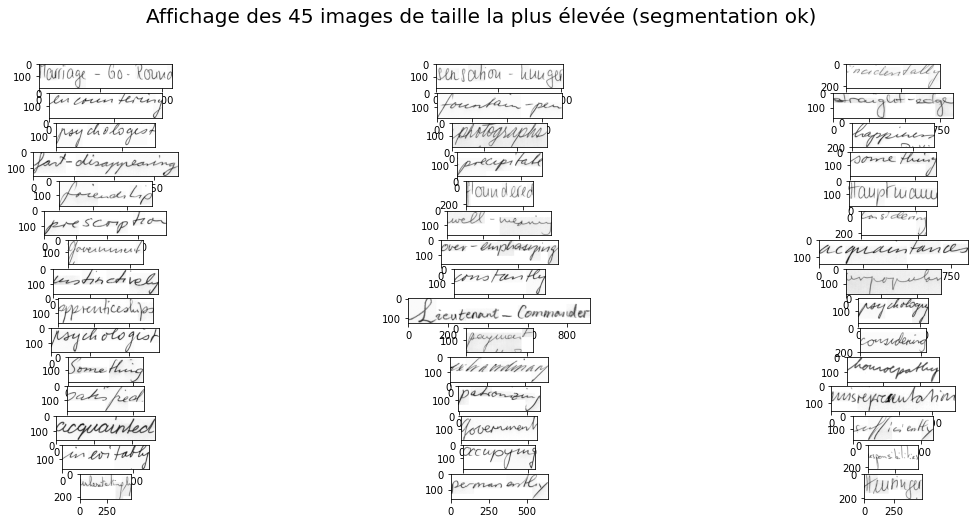

In [54]:
# A DEPLACER PLUS HAUT AVEC LE RESTE DES VISUS AVANT PREPROCESSING !!!

rd.show_45max_box_size_segmented_words_images(word_df)

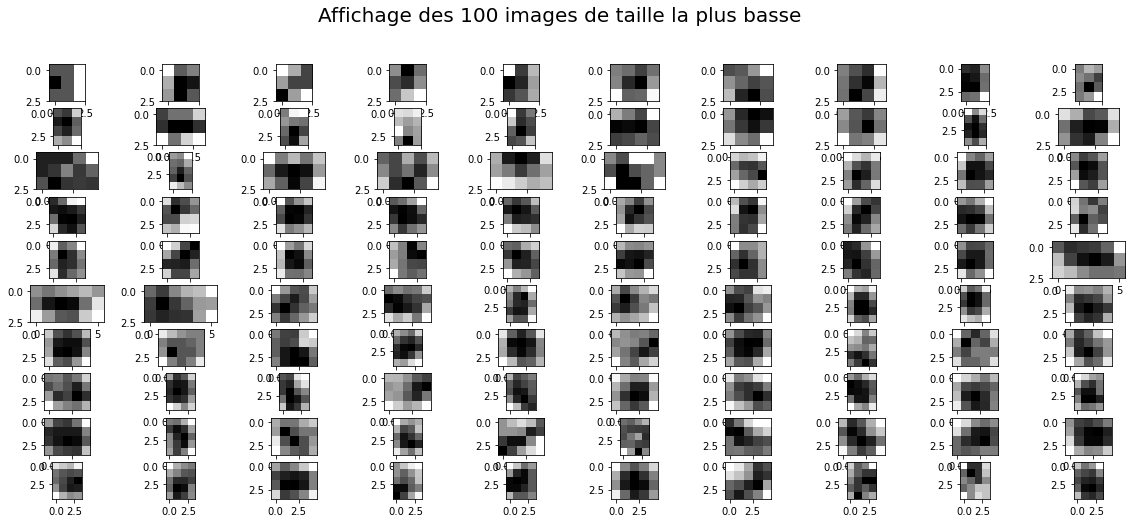

In [55]:


rd.show_100min_box_size_words_images(word_df)

## Styles d'écriture

Nous pouvons également nous intéresser aux différents styles d'écriture pouvant influencés la représentation d'une lettre. 

Nous pouvons supposer que chacun des rédacteurs a un style d'écriture qui lui est propre et nous intéresser aux nombres de styles existants pour chacune des lettres. 

Il serait par ailleurs peut être intéressant par la suite de générer des textes ayant différentes polices d'écriture pour diversifier davantage les représentations possibles d'une lettre.

In [ ]:
importlib.reload(rss)
importlib.reload(pp)
importlib.reload(dv)
importlib.reload(rd)

La répartition du nombre de formulaires écrits par rédacteur n'est pas uniforme, il faudra donc être prudent lors de la création des ensembles de training, validation et test (ne prendre qu'un seul formulaire par rédacteur pour chaque ensemble par ex)

## Analyse de la distributions des mots et caractères par rédacteur
(titre à confirmer)

Nombre de mots différents :  13549
Nombre de mots vues une seule fois :  7189
Nombre de mots vues 1000+ fois :  11


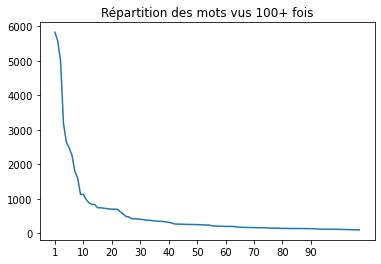

In [56]:
dv.show_words_repartition()

Beaucoup de mots ne sont vus qu'une seule fois, d'autres sont vus de très nombreuses fois, attention à l'overfitting

Nombre total de lettres :  475649
Nombre moyen de lettres par mot:  4.124636876837295


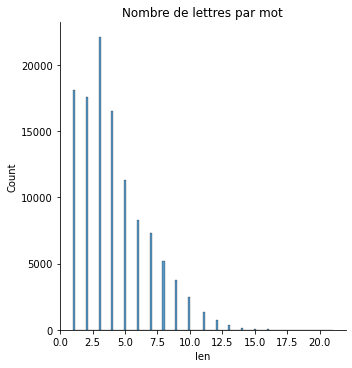

In [57]:
dv.show_letters_per_word()

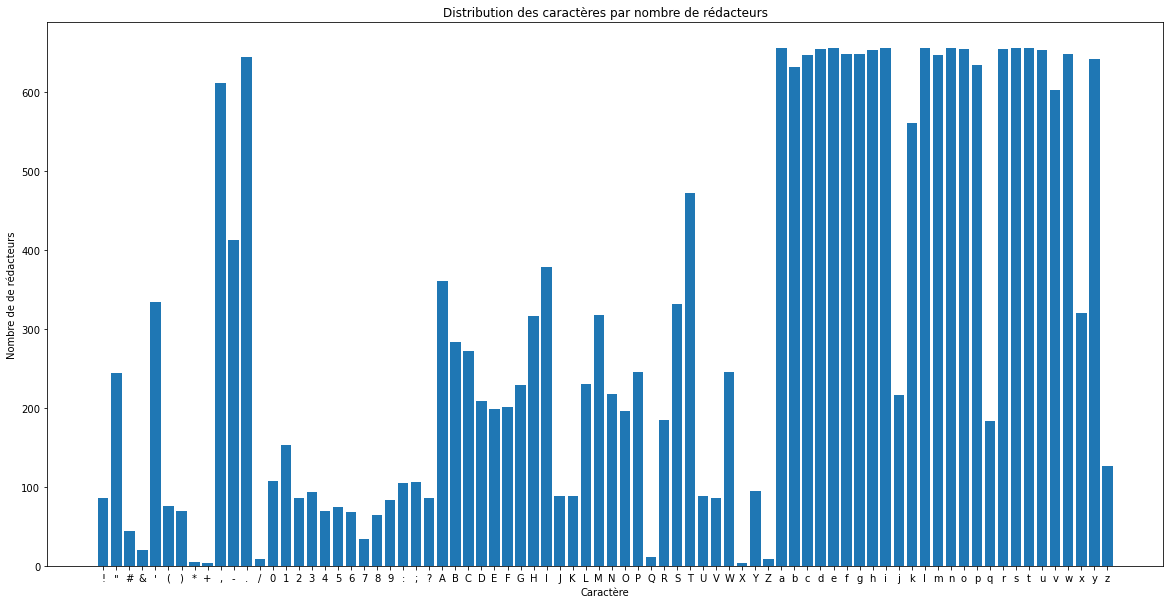

In [58]:
dv.show_caracters_distribution_per_writer(df_all)

Comme on pouvait s'y attendre, les lettres minuscules sont presque toutes au moins une fois représentées par un rédacteur. 

Nous voyons cependant que les lettres majuscules peuvent poser problème car elles ne sont parfois représentées que par moins de 100 rédacteurs différents.

Nous aurions pu également compter le nombre d'occurences de ces lettres pour chaque rédacteur afin de nous assurer qu'un style ne domine pas sur les autres car majoritairement représenté. 

Toutefois, l'impact d'une surreprésentation devrait pouvoir être négligé car les textes comportent tous un bon nombre de lettres différentes.

## Luminance

In [61]:
from PIL import Image

img = Image.open(word_df.iloc[0].word_img_path)
#Convert the image te RGB if it is a .gif for example
img = img.convert ('RGB')
#coordinates of the pixel
X,Y = 0,0
#Get RGB
pixelRGB = img.getpixel((X,Y))
R,G,B = pixelRGB 

brightness = sum([R,G,B])/3
brightness

249.0

## Détection des contours

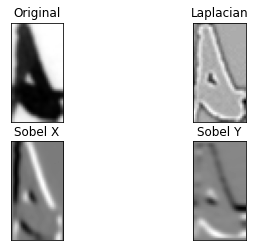

In [62]:
import cv2
import numpy as np
from matplotlib import pyplot as plt



img_arr = cv2.imread(word_df.iloc[0].word_img_path)
gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(gray,(3,3),0)

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=5)  
sobely = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=5)  


plt.subplot(2,2,1),
plt.imshow(img,cmap = 'gray')
plt.title('Original')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,2),
plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,4)
plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y')
plt.xticks([])
plt.yticks([])

plt.show()

../data/words/a01/a01-030/a01-030-00-08.png


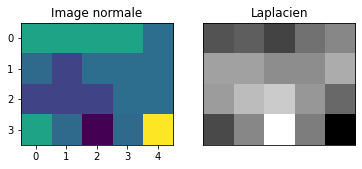

In [66]:
def get_laplacian_img_for_row(row):
    img_arr = cv2.imread(row.word_img_path)
    gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(gray,(3,3),0)
    return cv2.Laplacian(img,cv2.CV_64F)



bad_contrast_row = word_df[word_df['michelson_contrast'] <= 0.2].iloc[0]
laplacian_bad_constrast = get_laplacian_img_for_row(bad_contrast_row)
print(bad_contrast_row.word_img_path)

plt.subplot(1,2,1),
plt.title('Image normale')
plt.imshow(plt.imread(bad_contrast_row.word_img_path));
plt.subplot(1,2,2),
plt.imshow(laplacian_bad_constrast,cmap = 'gray');
plt.title('Laplacien')
plt.xticks([])
plt.yticks([])
plt.show()


In [69]:
first_writer_df = df_all[df_all['writer_id'] == '000']
print(len(first_writer_df))
print(len(df_all))

1308
59611


AttributeError: 'DataFrame' object has no attribute 'word_id'

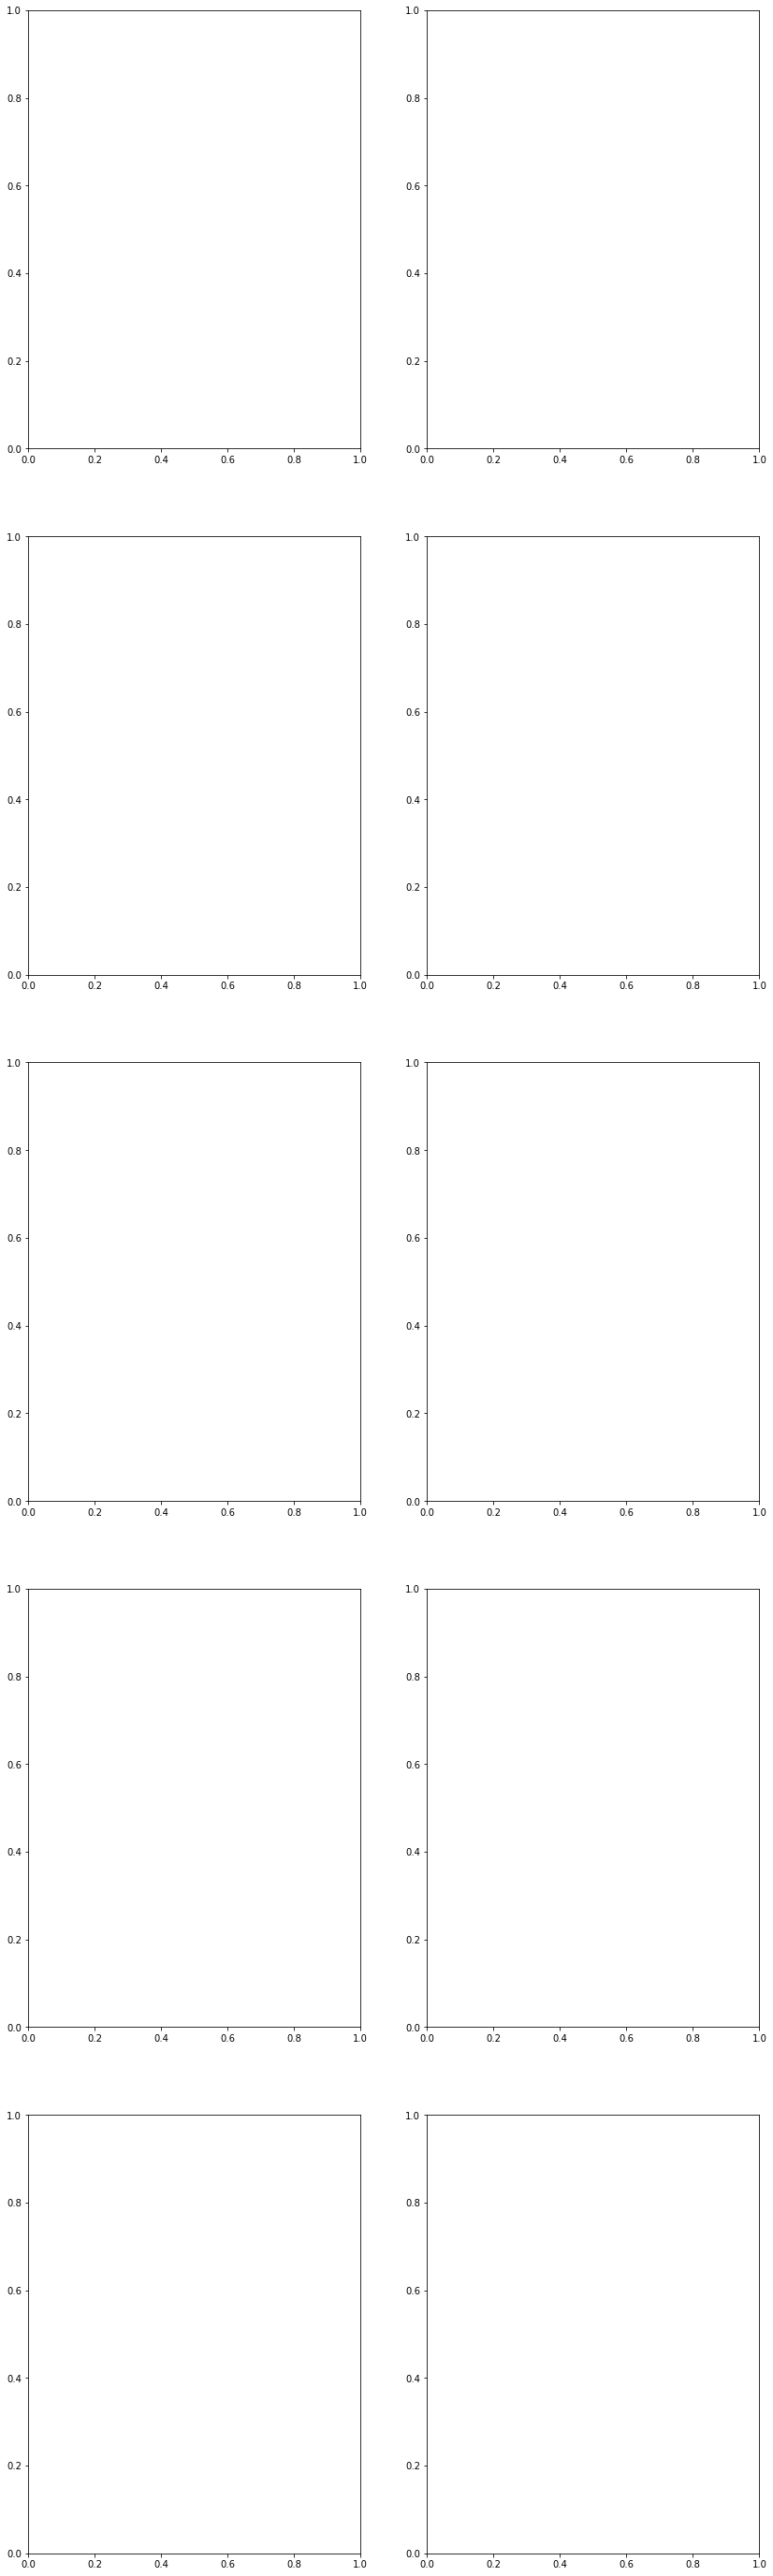

In [70]:
n_rows = 5
n_col = 2
n_images = n_rows * n_col
rand_list = np.sort(np.random.randint(0, first_writer_df.shape[0], n_images))


fig, ax = plt.subplots(n_rows,n_col, figsize=(14,50))
for i in range(n_rows):
    for j in range(n_col):
        img = plt.imread(pp.get_form_img_path_by_word_id(first_writer_df.word_id.iloc[rand_list[i+ j * n_col]]))
        ax[i, j].imshow(img, cmap = 'gray') ;